In [66]:
import numpy as np
import pandas as pd
from scipy.stats import norm as normal
from scipy.stats import multivariate_normal as mnormal

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [67]:
from IPython.display import display, HTML

In [68]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2020

&nbsp;
&nbsp;
&nbsp;
# Lab 5. Unsupervised Learning: Continuous Data

&nbsp;
&nbsp;
&nbsp;

**Ignacio Peis**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='https://www.uc3m.es/ss/Satellite?blobcol=urldata&blobkey=id&blobtable=MungoBlobs&blobwhere=1371573953235&ssbinary=true' width=400 />


# Introduction
In this lab session wou will study basic probabilistic models for continous data. You will fit a Gaussian distribution (in its univariate and multivariate versions) to a dataset composed by measures of body temperature and heart rate, in order to study correlations beetween the variables and analyze them from a Bayesian perspective. 

## Reminder: Bayesian modeling

During this notebook, we employ basic probabilistic notation for priors, likelihoods and posteriors. The expression $p(x | y)$ denotes a probability distribution (a mathematical function over the probability for each possible value of $x$) of variable $x$, once $y$ is given. Employing easy terms, we could say that $p(x | y)$ is a function over $x$ that includes a known 'parameter' $y$ inside. In Bayesian world, we use this notation when the probability of a variable $x$ depends on the value of other variable $y$. What if knowing $p(x|y)$, we want to obtain $p(y|x)$. We can use the **Bayes theorem**:
\begin{equation}
p(y|x) = \frac{p(x|y) p(y)}{p(x)}
\end{equation}
We are interested in finding the posterior distribution of a variable. The procedure is always the same: 
- First, we assume a model where some parameter $ \theta$ has a rol in the generation of data. 
- Second, we define a **prior** distribution over the parameter of interest, $p(\theta)$, that captures our a priori assumptions about how $\theta$ might be distributed, and a **likelihood** distribution, $p(\mathcal{D} | \theta)$, that measures how probable are your observations given a value of $\theta$.
- Third, we compute the **posterior** $p(\theta | \mathcal{D})$ using Bayes theorem. The posterior distribution incorporates knowledge from observed data and gives you a distribution of the parameters, given the **evidence** you have observed in $\mathcal{D}$. 
\begin{equation}
p(\theta|\mathcal{D}) = \frac{p(\mathcal{D}|\theta) p(\theta)}{p(\mathcal{D})}
\end{equation}
The denominator is a normalization constant called *evidence*. As it is constant, we will ignore it to compute the posterior distribution, using:
\begin{equation}
p(\theta|\mathcal{D}) \propto p(\mathcal{D}|\theta) p(\theta)
\end{equation}
The posterior distribution will give you the values of $\theta$ that are more probable, given your dataset. Different approaches can be employed to obtain an estimation for the parameter of interest $\hat{\theta}$.


## 1.1. Dataset
The dataset $\mathcal{D}$ is composed by $N=130$ observations of dimension $D=2$, in the form:

$\textbf{y}_i = [y_1, y_2] \qquad$ with $y_i \in \mathbb{R}  \qquad \mathcal{D}= \{ \textbf{y}_1, ..., \textbf{y}_N \} \qquad$

We use a dataset composed by two features with measurements of body temperature ($ºC$), $y_1$ and heart rate ($ppm$), $y_2$, respectively. We employ framework <a href="https://pandas.pydata.org/docs/reference/index.html#api">pandas</a> for reading the dataset. For the first part of the notebook (univariate Gaussian), you will model each of these dimensions separately, while, for the second part, you will implement a joint model using a multivariate Gaussian.


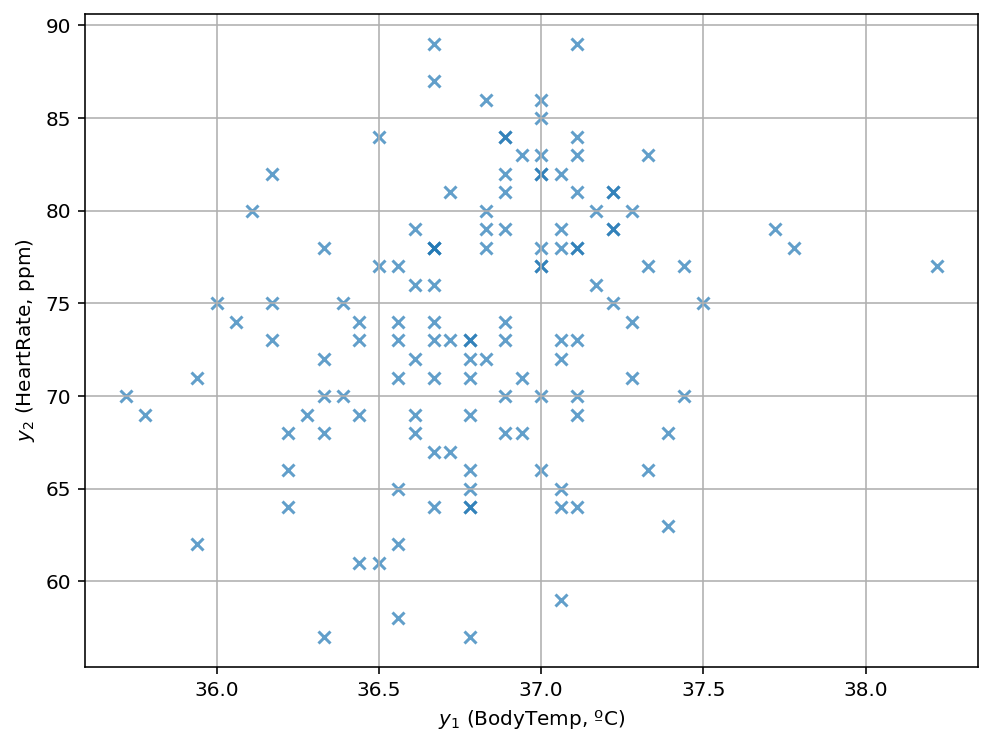

In [69]:
# Read the dataset
# If you run locally, set use_colab=False
use_colab=False

if use_colab==True:
    # To work in colab
    from google.colab import files
    uploaded = files.upload()
    import io
    data = pd.read_csv(io.BytesIO(uploaded['dataset.csv']), index_col=0)

else:
    data = pd.read_csv('dataset.csv', index_col=0)
    
data = pd.read_csv('dataset.csv', index_col=0)
D = 2

Y1 = data['BodyTemp']
Y2 = data['HeartRate']

plt.figure(figsize=(8, 6))
plt.scatter(Y1, Y2, marker='x', alpha=0.7) # alpha adds transparency to see overlapped points
plt.grid()
plt.xlabel(r'$y_1$ (BodyTemp, ºC)')
t=plt.ylabel(r'$y_2$ (HeartRate, ppm)')


# 1. The univariate Gaussian
The Gaussian (also referred as the Normal) distribution is the most widely used in statistics and machine learning for modeling continuous real-valued data. The probability density function (pdf) for the univariate case (one dimension) is given by:
\begin{equation}
\mathcal{N}(x | \mu, \sigma^2 ) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{1}{2\sigma^2}(x-\mu)^2}
\end{equation}

The Gaussian distribution is determined by two parameters: the mean $\mu$ (that also coincides with the mode) and the variance $\sigma^2$. The former is the "shift" of the distribution from $x=0$, while the latter controls the width of the distribution. Some examples are included below.



*Note: the univariate Gaussian probability function can be used in this notebook. Use <code>normal.pdf(x, mu, sigma)</code> to compute the probability of <code>x</code> with parameters <code>mu</code> and <code>sigma</code>. Remember: <code>var=sigma**2</code>*.


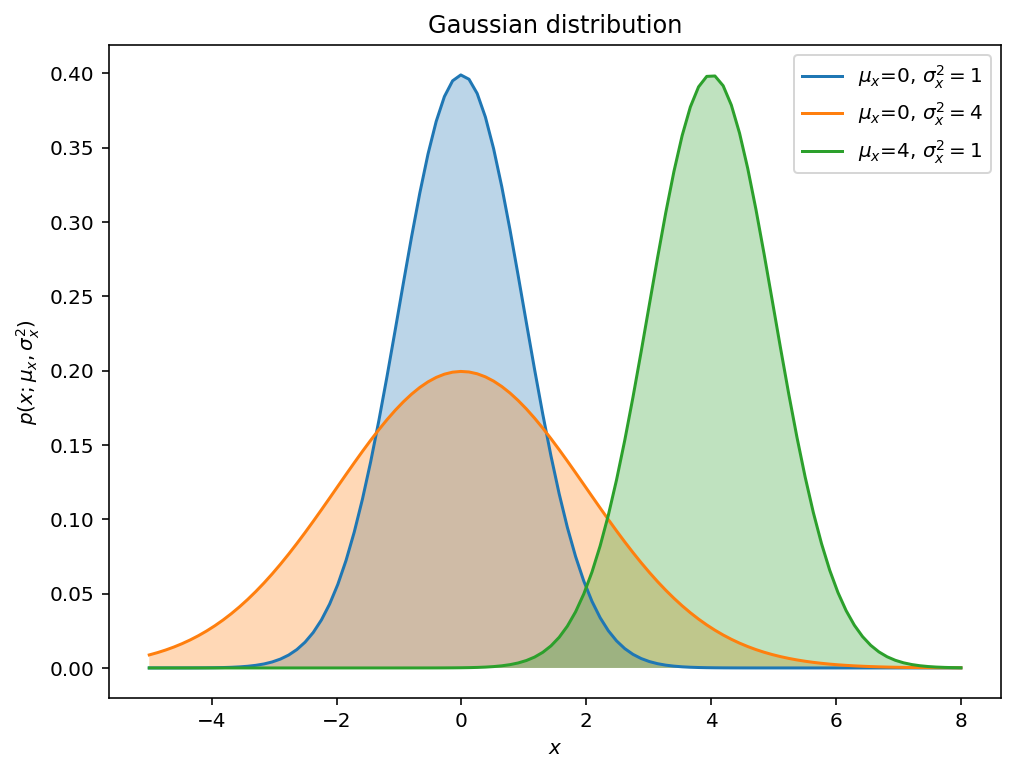

In [70]:
# Visualizing the Gaussian distribution
mu_list = [0, 0, 4]        # 3 possible values of mu_x
sigma_list = [1, 2, 1]        # 3 possible values of sigma_x (SQRT(VAR)!)
x_domain = np.linspace(-5, 8, 100)    # 100 real points beween -2 and 8

plt.figure(figsize=(8, 6))
for mu, sigma in zip(mu_list, sigma_list):
    p = normal.pdf(x_domain, mu, sigma)
    plt.plot(x_domain, p, label=r'$\mu_x$=' + str(mu) + ', $\sigma_x^2=' + str(sigma**2) + '$')
    plt.fill_between(x_domain, 0, p, alpha=0.3 )
plt.legend(loc='best')
plt.xlabel(r'$x$')
plt.ylabel(r'$ p(x; \mu_x, \sigma_x^2) $')
ttl=plt.title('Gaussian distribution')

## 1.2. Model for noisy measurements
We asume that each observation $y_i$ is a noisy version of the true value $x$, i.e., $x$ is corrupted by gaussian noise $z_i$ and the result $y_i$ is observed:
\begin{equation}
y_i = x + z_i \qquad p(z) = \mathcal{N}(z | 0, \sigma_y^2)
\end{equation}
The noise $z_i$ is just a random deviation of the true value $x$. We model it as a Gaussian with $0$-mean and a defined variance $\sigma_y^2$. The noise variace $\sigma_y^2$ has to be defined.

*Just for comparison: in the previous notebook our parameter was $\theta$. In this case, our "parameter" is the true value $x$ that generated the data. Then, we put a prior over $x$ and the likelihood is $p(y|x)$.*
### 1.2.1. Prior
We put a prior over the true value of $x$ (that can be any value in $\mathbb{R}$) so we assume a Gaussian with defined mean $\mu_0$ and $\sigma_0^2$:
\begin{equation}
p(x) = \mathcal{N}(x|\mu_0, \sigma_0^2)
\end{equation}
This prior is an idea of how could be distributed the variable of interest. The posterior will be influenced by the choice of this distribution, as well as the observations in the dataset.

### 1.2.2. Likelihood
The likelihood follows another Gaussian distribution. As each $y_i$ is a noisy version of $x$, the mean is $x$ and the variance is the same as the noise, $\sigma^2$. To obtain the likelihood of all the samples, we multiply:
\begin{equation}
p(y_i|x) = \mathcal{N}(y_i | x, \sigma_y^2) \qquad p(\mathcal{D} | x, \sigma_y^2) = \prod_{i=1}^N p(y_i | x)
\end{equation}


### 1.2.3. Posterior
The posterior can be derived using Bayes Theorem:
\begin{gather}
\begin{matrix}
p(x|\mathcal{D}) &\propto & \prod_{i=1}^N\mathcal{N}(y_i|x, \sigma_y^2) \mathcal{N}(x|\mu_0, \sigma_0^2) \\
& = & \mathcal{N} \left( x \vert \frac{N\sigma_0^2}{N\sigma_0^2 + \sigma_y^2} \bar{y} + \frac{\sigma_y^2}{N\sigma_0^2 + \sigma_y^2}\mu_0, \frac{\sigma_0^2 \sigma_y^2}{N\sigma_0^2 + \sigma_y^2}\right)
\end{matrix}
\end{gather}
which corresponds to another Gaussian distribution with parameters:
\begin{gather}
\mu_{post} = \frac{N\sigma_0^2}{N\sigma_0^2 + \sigma_y^2} \bar{y} + \frac{\sigma_y^2}{N\sigma_0^2 + \sigma_y^2}\mu_0 \\
\sigma_{post}^2 = \frac{\sigma_0^2 \sigma_y^2}{N\sigma_0^2 + \sigma_y^2}
\end{gather}
where $\bar{y}$ is the *empirical* mean, given by $\bar{y}=\frac{1}{N}\sum_{i=1}^N y_i$.

## 1.3. Experiments

### 1.3.1. Computing the posterior distribution

**Compute the parameters and plot the univariate posterior distributions for each of the two continuos variables of the dataset: BodyTemp and HeartRate (in two different plots). Use a standard Normal for the prior ($\mu_0=0$, $\sigma_0^2=1$) and a variance of 1 for the noise for both cases**.

*Suggestion: include in each of the plots the corresponding dataset points in the x-axis, using:*
<code>ax.scatter(Y, np.zeros_like(Y), marker='x', color='tab:blue', alpha=0.4)</code>
*where <code>Y</code> is the corresponding variable, BodyTemp or HeartRate.*

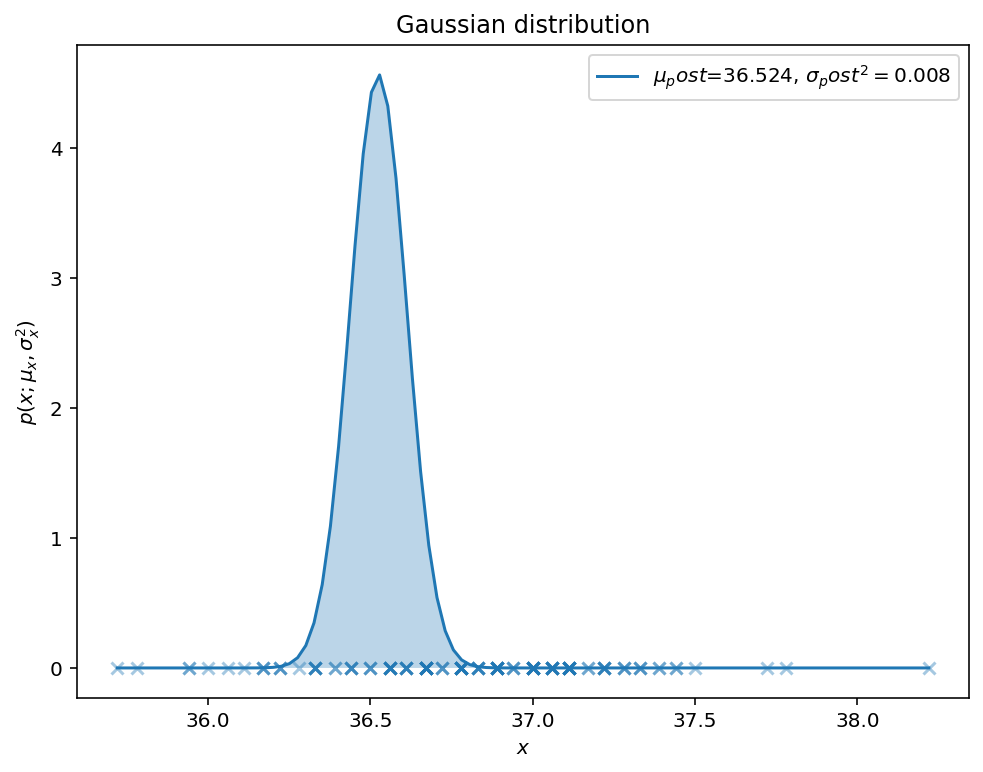

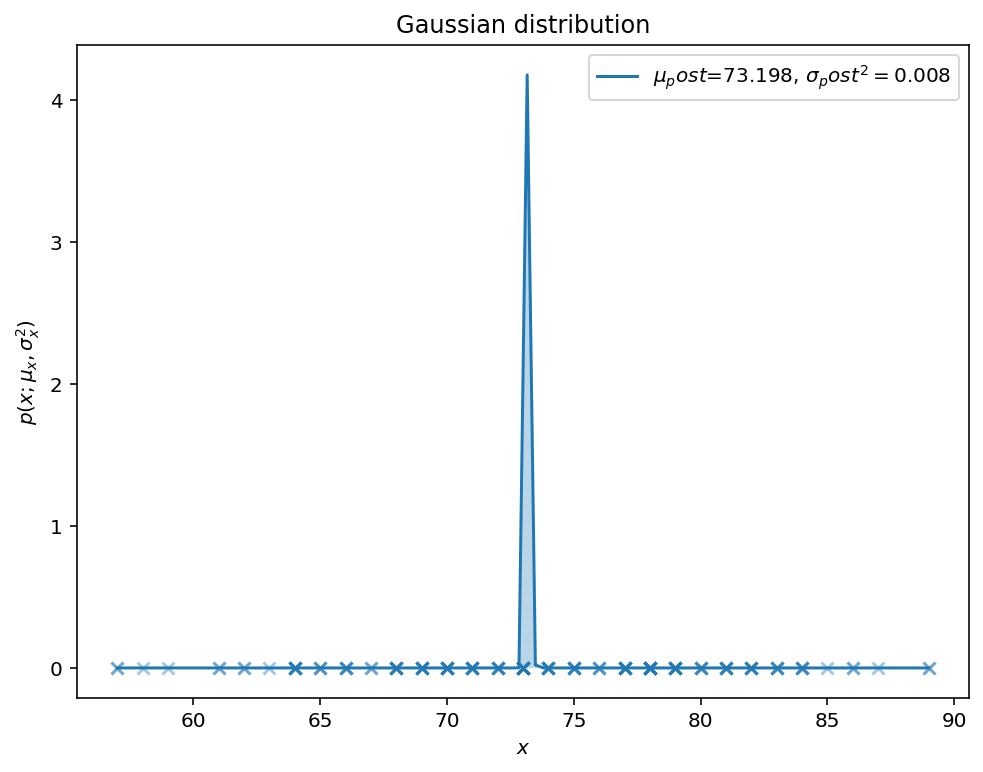

In [71]:
def post_gaussian(mu0, var0, var_y, y):
    mean_y = np.mean(y)
    N = len(y)
    denom = N * var0 + var_y
    mu_post = (N * var0 *mean_y/denom) + (var_y * mu0/denom)
    var_post = var0 * var_y/denom
    return mu_post, var_post

# Noise parameter
var_y=1

# BodyTemp
Y=data['BodyTemp'].values
y_domain = np.linspace(np.min(Y), np.max(Y), 100) # Use it to plot the Gaussian

mu,var = post_gaussian(0, 1, var_y, Y)
sigma = np.sqrt(var)

plt.figure(figsize=(8, 6))
p = normal.pdf(y_domain, mu, sigma)
plt.plot(y_domain, p, label=r'$\mu_post$=' + str(round(mu,3)) + ', $\sigma_post^2=' + str(round(sigma**2,3)) + '$')
plt.fill_between(y_domain, 0, p, alpha=0.3 )
plt.legend(loc='best')
plt.xlabel(r'$x$')
plt.ylabel(r'$ p(x; \mu_x, \sigma_x^2) $')
ttl=plt.title('Gaussian distribution')
ax = plt.subplot()
ax.scatter(Y, np.zeros_like(Y), marker='x', color='tab:blue', alpha=0.4)

# HeartRate
Y=data['HeartRate'].values
y_domain = np.linspace(np.min(Y), np.max(Y), 100) # Use it to plot the Gaussian

mu,var = post_gaussian(0, 1, var_y, Y)
sigma = np.sqrt(var)

plt.figure(figsize=(8, 6))
p = normal.pdf(y_domain, mu, sigma)
plt.plot(y_domain, p, label=r'$\mu_post$=' + str(round(mu,3)) + ', $\sigma_post^2=' + str(round(sigma**2,3)) + '$')
plt.fill_between(y_domain, 0, p, alpha=0.3 )
plt.legend(loc='best')
plt.xlabel(r'$x$')
plt.ylabel(r'$ p(x; \mu_x, \sigma_x^2) $')
ttl=plt.title('Gaussian distribution')
ax = plt.subplot()
ax.scatter(Y, np.zeros_like(Y), marker='x', color='tab:blue', alpha=0.4)


### 1.3.2. Influence of the prior

**Change the prior and the noise variance for both variables to one that you think is more appropiated on each case. Remember, setting a prior means that you expect the values of $x$ to be centered around $\mu_0$, with a deviation of $\sigma_0$. The noise, in this case, can represent how can variate each variable from one person to another. Set $\sigma_y^2=3^2$ for BodyTemp and $\sigma_y^2=35^2$ for HeartRate. Observe how the new posteriors change.**


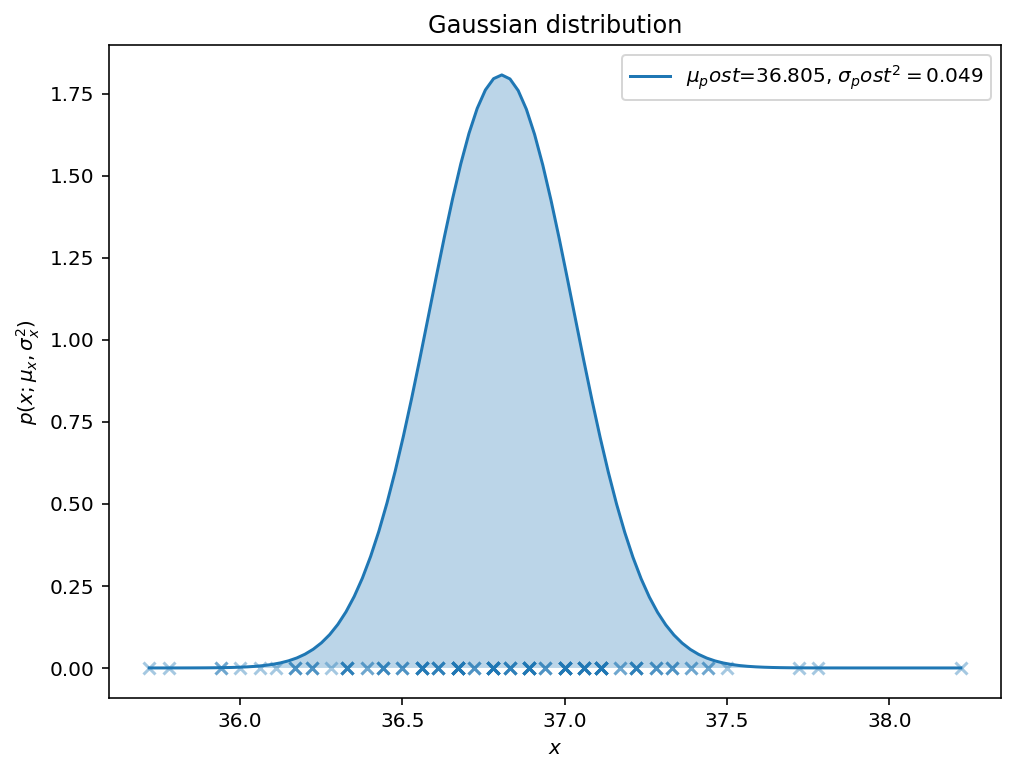

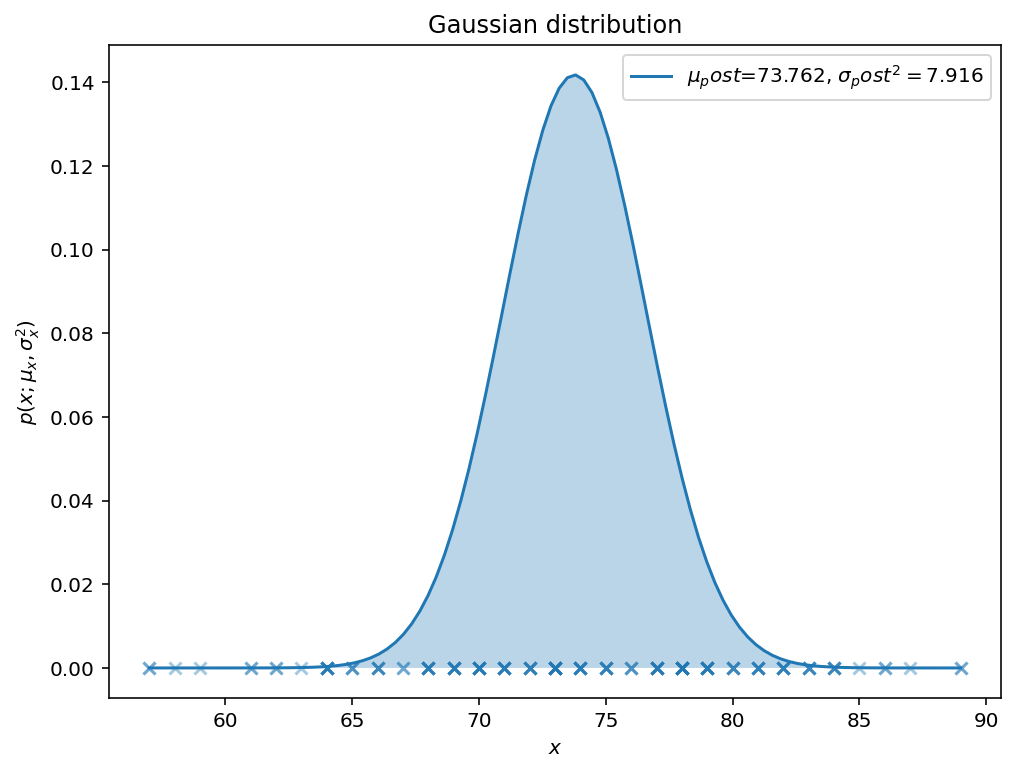

In [72]:
# BodyTemp
Y=data['BodyTemp'].values
y_domain = np.linspace(np.min(Y), np.max(Y), 100) # Use it to plot the Gaussian
# Noise parameter
var_y=3**2

mu0, var0 = np.mean(Y),np.var(Y)
mu,var = post_gaussian(mu0, var0, var_y, Y)
sigma = np.sqrt(var)

plt.figure(figsize=(8, 6))
p = normal.pdf(y_domain, mu, sigma)
plt.plot(y_domain, p, label=r'$\mu_post$=' + str(round(mu,3)) + ', $\sigma_post^2=' + str(round(sigma**2,3)) + '$')
plt.fill_between(y_domain, 0, p, alpha=0.3 )
plt.legend(loc='best')
plt.xlabel(r'$x$')
plt.ylabel(r'$ p(x; \mu_x, \sigma_x^2) $')
ttl=plt.title('Gaussian distribution')
ax = plt.subplot()
ax.scatter(Y, np.zeros_like(Y), marker='x', color='tab:blue', alpha=0.4)



# HeartRate
Y=data['HeartRate'].values
y_domain = np.linspace(np.min(Y), np.max(Y), 100) # Use it to plot the Gaussian
# Noise parameter
var_y=35**2

mu0, var0 = np.mean(Y),np.var(Y)
mu,var = post_gaussian(mu0, var0, var_y, Y)
sigma = np.sqrt(var)

plt.figure(figsize=(8, 6))
p = normal.pdf(y_domain, mu, sigma)
plt.plot(y_domain, p, label=r'$\mu_post$=' + str(round(mu,3)) + ', $\sigma_post^2=' + str(round(sigma**2,3)) + '$')
plt.fill_between(y_domain, 0, p, alpha=0.3 )
plt.legend(loc='best')
plt.xlabel(r'$x$')
plt.ylabel(r'$ p(x; \mu_x, \sigma_x^2) $')
ttl=plt.title('Gaussian distribution')
ax = plt.subplot()
ax.scatter(Y, np.zeros_like(Y), marker='x', color='tab:blue', alpha=0.4)



### 1.3.3 Influence of the dataset size
**Plot in the same figure the curves with the posterior of BodyTemp when using only the first N=[1, 10, ..., 100] samples from the dataset. Repeat this process two times: 1) Using standard prior 2) Using your decided prior. Include the samples in the x-axis. Set $\sigma_y^2=3^2$.**


c:\Users\migue\anaconda4\envs\ML\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


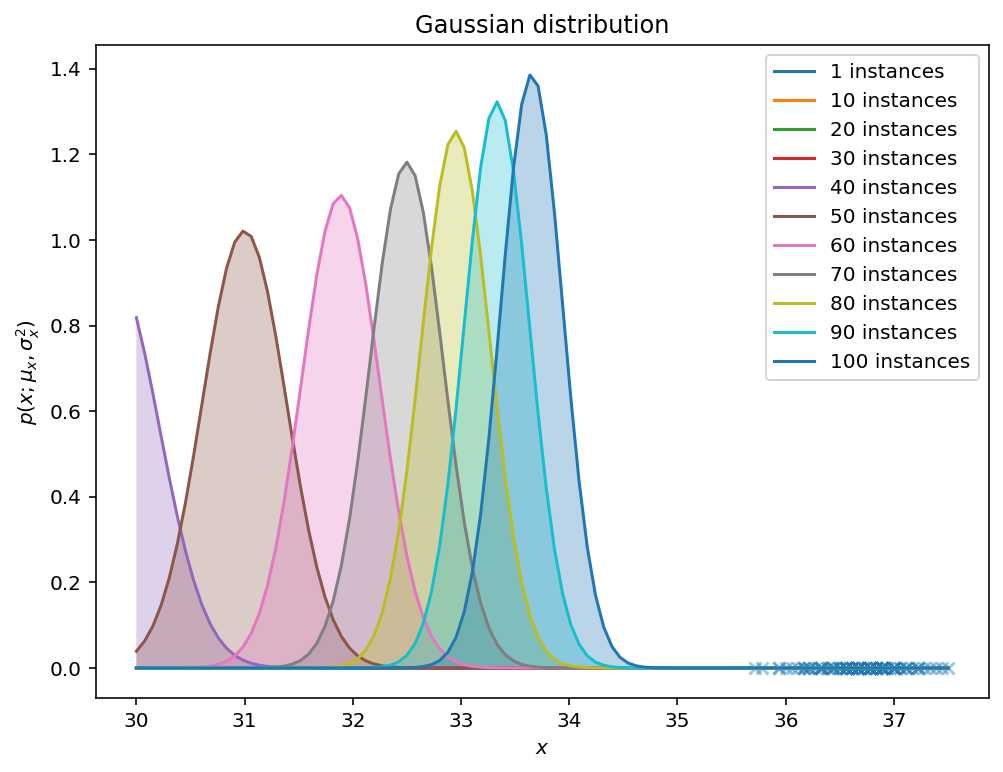

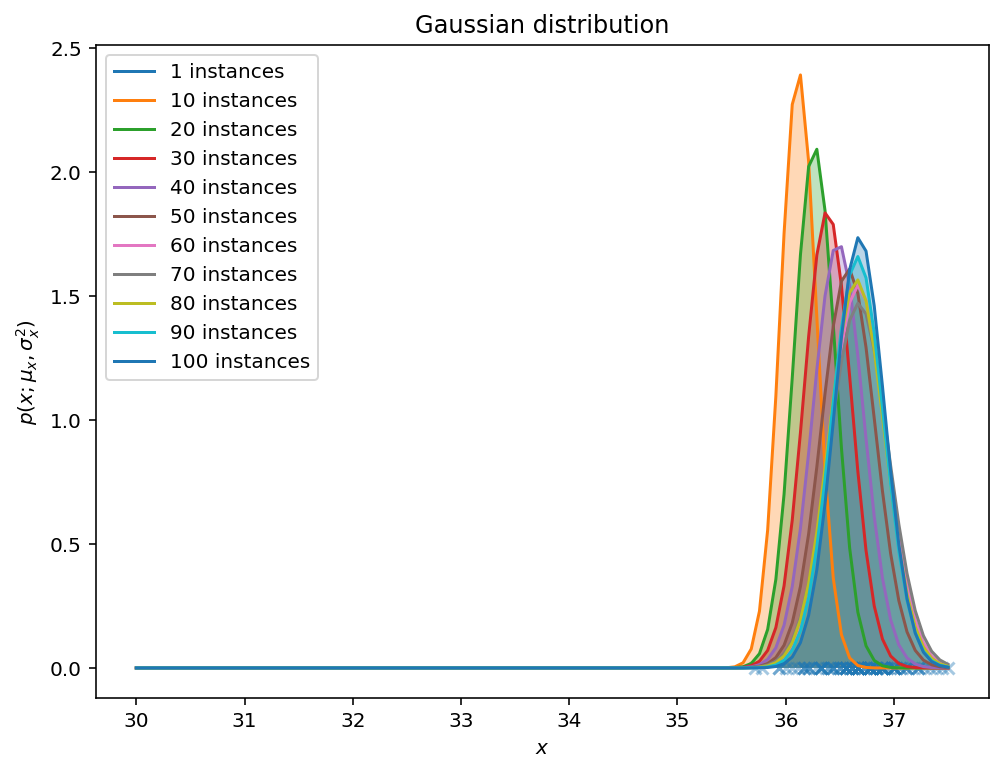

In [77]:

# Noise parameter
var_y=3**2

y_domain = np.linspace(30, 37.5, 100)
Ns = np.arange(11)*10
Ns[0]=1

mu_list = []        # 3 possible values of mu_x
sigma_list = []        # 3 possible values of sigma_x (SQRT(VAR)!)

#Standard Prior
for i in Ns:
    Y=data['BodyTemp'].values[:i]
    mu0, var0 = 0,1
    mu,var = post_gaussian(mu0, var0, var_y, Y)
    sigma = np.sqrt(var)

    mu_list.append(mu)
    sigma_list.append(sigma)

plt.figure(figsize=(8, 6))
for mu, sigma, n in zip(mu_list, sigma_list, Ns):
    p = normal.pdf(y_domain, mu, sigma)
    plt.plot(y_domain, p, label=str(n) + ' instances')
    plt.fill_between(y_domain, 0, p, alpha=0.3 )
plt.legend(loc='best')
plt.xlabel(r'$x$')
plt.ylabel(r'$ p(x; \mu_x, \sigma_x^2) $')
ttl=plt.title('Gaussian distribution')
ax = plt.subplot()
ax.scatter(Y, np.zeros_like(Y), marker='x', color='tab:blue', alpha=0.4)

mu_list = []        # 3 possible values of mu_x
sigma_list = []        # 3 possible values of sigma_x (SQRT(VAR)!)

#Our Prior
for i in Ns:
    Y=data['BodyTemp'].values[:i]
    mu0, var0 = np.mean(Y),np.var(Y)
    mu,var = post_gaussian(mu0, var0, var_y, Y)
    sigma = np.sqrt(var)
    
    mu_list.append(mu)
    sigma_list.append(sigma)

plt.figure(figsize=(8, 6))
for mu, sigma,n  in zip(mu_list, sigma_list, Ns):
    p = normal.pdf(y_domain, mu, sigma)
    plt.plot(y_domain, p, label=str(n) + ' instances')
    plt.fill_between(y_domain, 0, p, alpha=0.3 )
plt.legend(loc='best')
plt.xlabel(r'$x$')
plt.ylabel(r'$ p(x; \mu_x, \sigma_x^2) $')
ttl=plt.title('Gaussian distribution')
ax = plt.subplot()
ax.scatter(Y, np.zeros_like(Y), marker='x', color='tab:blue', alpha=0.4)


### Questions
**Give a answer of the following questions, based on the analysis of the plots you have obtained:**

**1. Do you think the posterior distribution of HeartRate for a standard prior and noise with $\sigma^2=1$ is realistic? Why?**.
- No, using the standard prior, the plot does not represent correctly the real variance of the sample because the curve is very narrow while it should be wider as we saw using our own prior.

**2. Do you see a tendency of the posterior when increasing the number of observations $N$? Which differences do you notice between using the standard prior and your defined prior?**.
- As higher is the number of instances, more reliable is our curve comparing to the real data points. Furthermore, using our own prior we can observe that the curve is just above the data points which means we can get a better interpretation. Therefore, using our prior the mean is more centered respect to the real data and the variance fits properly.


# 2. The Multivariate Gaussian
In this second section we study the multivariate Gaussian distribution. We model vectors of real components with correlations among them. A multivariate Gaussian distribution is parameterized by a mean $\boldsymbol{\mu}$, which is the center of the distribution, and a covariance matrix $\Sigma$ with dimensions $D\times D$, which measures the covariances among variables $i$ and $j$ on each element $\Sigma_{ij}$. The pdf of the multivariate Gaussian is given by:
\begin{equation}
\mathcal{N}(\textbf{x} | \boldsymbol{\mu}, \Sigma) = \frac{1}{(2\pi)^{D/2} \lvert\Sigma\rvert^{1/2}} \text{exp} \left[ -\frac{1}{2}(\textbf{x}- \boldsymbol{\mu})^T \Sigma^{-1}(\textbf{x}- \boldsymbol{\mu}) \right]
\end{equation}

*$\text{Note}^1$: we call an "isotropic" Gaussian to the case where $\Sigma=\sigma^2 \textbf{I}$. The contour of the probability mass in this case is circular (first plot, below)*

*$\text{Note}^2$: the multivariate Gaussian probability function can be used in this notebook. Use <code>mnormal.pdf(x, mu, Sigma)</code> to compute the probability of <code>x</code> with parameters <code>mu</code> and <code>Sigma</code>. Remember: <code>mu</code> is a vector, and <code>Sigma</code> is a matrix*.


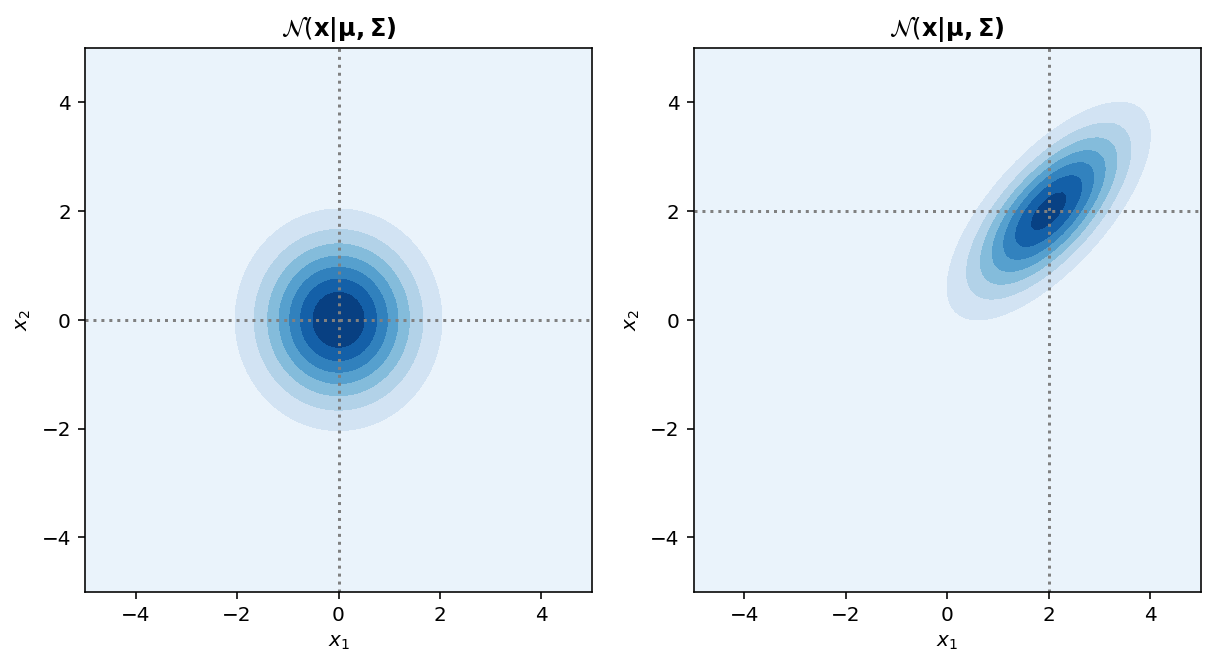

In [74]:


def plot_bi_gaussian(mu, Sigma, x1grid, x2grid, ax):
    """Plot a multivariate Gaussian with parameters mu and Sigma in the region given by x1grid and x2grid, using axes ax.
    `mu`: mean, vector of dimension D
    `Sigma`: covariance matrix of dimension DxD.
    `x1grid`: region for first dimension, vector of any dimension N.
    `x2grid`: region for second dimension, vector with same dimension as x1grid.
    `ax`: ax object to plot.
    """
    X1, X2 = np.meshgrid(x1grid, x2grid)
    # Pack X and Y into a single 3-dimensional array
    X = np.empty(X1.shape + (2,))
    X[:, :, 0] = X1
    X[:, :, 1] = X2
    p = mnormal.pdf(X, mu, Sigma)
    cset = ax.contourf(X1, X2, p, cmap = plt.cm.Blues)
    ax.axvline(mu[0], linestyle=':', color='gray')
    ax.axhline(mu[1], linestyle=':', color='gray')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_title(r'$\mathcal{N}(\bf{x} | \bf{\mu}, \Sigma)$')


x1 = np.linspace(-5, 5, 100)  # First dimension
x2 = np.linspace(-5, 5, 100)  # Second dimension

f, ax = plt.subplots(1,2, figsize=(10, 5))

# Zero-mean, Isotropic Gaussian
mu = np.zeros(2)
Sigma = np.eye(2)
plot_bi_gaussian(mu, Sigma, x1, x2, ax[0])

# Changing the parameters
mu = np.zeros(2)+2
Sigma = np.array([[1,1.5], [0.7, 1]])
plot_bi_gaussian(mu, Sigma, x1, x2, ax[1])

## 2.2. Model: multidimensional noisy measurements

The model for multidimensional noisy is a generalization of the univariate model, considering real-valued vectors:
\begin{equation}
\textbf{y}_i = \textbf{x} + \textbf{z}_i \qquad p(\textbf{z}) = \mathcal{N}(\textbf{z} | \textbf{0}, \Sigma_y)
\end{equation}
where $\textbf{0}$ (note the bold style) is a vector of $D$ zeros and $\Sigma$ is the defined covariance $D\times D$ matrix.

### 2.2.1. Prior
The prior is a multivariate Gaussian on $\textbf{x}$:
\begin{equation}
p(x) = \mathcal{N}(\textbf{x}|\boldsymbol{\mu}_0, \Sigma_0)
\end{equation}
We have to choose the parameters $\boldsymbol{\mu}_0$ and $\Sigma_0$ according to the case. Each $\Sigma_{ij}$ contains the covariance of dimensions $i$ and $j$. Elements on the diagonal are variances of each dimension. We typically set a diagonal matrix for the prior.

### 2.2.2. Likelihood
The likelihood of each sample follows another multivariate Gaussian distribution. To obtain the likelihood of all the samples, again, we multiply:
\begin{equation}
p(\textbf{y}_i | \textbf{x}) = \mathcal{N}(\textbf{y}_i | \textbf{x}, \Sigma_y) \qquad p(\mathcal{D} | \textbf{x}, \Sigma_y) = \prod_{i=1}^N \mathcal{N}(\textbf{y}_i | \textbf{x}, \Sigma_y)
\end{equation}


### 2.2.3. Posterior
The posterior can be derived using Bayes Theorem:
\begin{gather}
\begin{matrix}
p(\textbf{x}|\mathcal{D}) & \propto & \prod_{i=1}^N\mathcal{N}(\textbf{y}_i|\textbf{x}, \Sigma_y) \mathcal{N}(\textbf{x}|\boldsymbol{\mu}_0, \Sigma_0) \\
& = & \mathcal{N} (\boldsymbol{\mu_N}, \Sigma_N)
\end{matrix}
\end{gather}
which corresponds to another Gaussian distribution with parameters:
\begin{gather}
\Sigma_N^{-1} = \Sigma_0^{-1} + N\Sigma_y^{-1} \\
\boldsymbol{\mu}_N = \Sigma_N(\Sigma_y^{-1}(N\bar{\textbf{y}}) + \Sigma_0^{-1}\boldsymbol{\mu}_0)
\end{gather}
where $\bar{\textbf{y}}$ is the *empirical* mean, given by $\bar{\textbf{y}}=\frac{1}{N}\sum_{i=1}^N \textbf{y}_i$.

*Extra note: $\Sigma^{-1}$ is called the precision matrix of the distribution. Is another way of parameterization  for Gaussian distributions.*


## 2.3. Inference in jointly Gaussian distributions
The multivariate distribution $p(\textbf{x})$ with dimensions $x_1$ and $x_2$ is equivalent to the joint distribution $p(x_1, x_2)$. If we consider each dimension, we can compute marginals $p(x_1)$ and $p(x_2)$ and conditionals $p(x_1 | x_2)$ and $p(x_2 | x_1)$. For example, the posterior conditional distribution of $x_2$ given a value of $x_1$ is given by:

\begin{equation}
p(x_2 | x_1) = \frac{p(x_2, x_1)}{p(x_1)} = \mathcal{N} (x_2 | \mu_{2|1}, \sigma_{2|1}^2 )
\end{equation}
where:

\begin{gather}
\mu_{2|1} = \mu_2 + \Sigma_{21} \Sigma_{11}^{-1}(x_1-\mu_1) \\
\sigma_{2|1}^2 = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}
\end{gather}

## 2.3. Experiments

### 2.3.1. Computing the posterior distribution

**Compute the parameters of the posterior distribution and plot along with the samples of the dataset. Use the given prior parameters and noise parameters.**


In [75]:
def post_mgaussian(Y, mu0, Sigma0, Sigma_y):
    #############
    #           #
    # YOUR CODE #
    #           #
    #############

    return mu_N, Sigma_N


# Load dataset
Y = data[['BodyTemp', 'HeartRate']].values

# Noise params
Sigma_y = np.array([[5**2, 10**2], [10**2, 50**2]])

# Prior params
mu0 = np.array([36.5, 70])
Sigma0 = np.array([[3**2, 0], [0, 20**2]])


#############
#           #
# YOUR CODE #
#           #
#############




### 2.3.2. Posterior conditional 

**Compute the posterior conditional distribution of the HeartRate given the BodyTemp, $p(x_2|x_1)$, for $x_1=35ºC$ and $x_1=38ºC$. Plot the two distributions in the same figure.**

In [76]:

def cond_gaussian(mu, Sigma, y1):
    #############
    #           #
    # YOUR CODE #
    #           #
    #############

    return mu_21, var_21



y2 = Y[:, 1]
y_domain = np.linspace(np.min(y2), np.max(y2), 100)

# HeartRate=35

#############
#           #
# YOUR CODE #
#           #
#############


# HeartRate=38

#############
#           #
# YOUR CODE #
#           #
#############





## Questions

**1. Are the Body Temperature and Heart Rate strongly correlated variables? *Hint: take a look at the elements out of the diagonal of $\Sigma_N$***.

- Your answer.

**2. How is it reflected on the conditional posterior? Do you notice big differences on the heart rate from the two temperatures proposed? Could we differenciate between a patient with fever by only watching his/her heart rate?**.

- Your answer.

**3. Given that, is the multivariate normal helping when modeling the two variables together? What if we modeled the height and weight for a group of people? Would you think the conditional posteriors would give us more information? Could we have a guess of the weight, given the height of a person?**

- Your answer.


## References

[1]. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.

[2]. Bishop, C. M. (2006). Pattern recognition and machine learning. springer.

